In [1]:
#!/usr/bin/env python
# coding: utf-8

# This script generates the MINICIFAR dataset from CIFAR10
# The following parameters can be changed : 
# n_classes (between 2 and 10) 
# Reduction factor R (which will result in 10000 /  R examples per class for the train set, and 1000 / R per class for test)
# --


n_classes_minicifar = 4
R = 5


# Download the entire CIFAR10 dataset

from torchvision.datasets import CIFAR10
import numpy as np 
from torch.utils.data import Subset

import torchvision.transforms as transforms

## Normalization is different when training from scratch and when training using an imagenet pretrained backbone

normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

normalize_forimagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# Data augmentation is needed in order to train from scratch
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

## No data augmentation when using Transfer Learning
transform_train_imagenet = transforms.Compose([
    transforms.ToTensor(),
    normalize_forimagenet,
])

transform_test_imagenet = transforms.Compose([
    transforms.ToTensor(),
    normalize_forimagenet,
])


### The data from CIFAR10 will be downloaded in the following dataset
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

c10train_imagenet = CIFAR10(rootdir,train=True,download=True,transform=transform_train_imagenet)
c10test_imagenet = CIFAR10(rootdir,train=False,download=True,transform=transform_test_imagenet)

# Generating Mini-CIFAR
# 
# CIFAR10 is sufficiently large so that training a model up to the state of the art performance will take approximately 3 hours on the 1060 GPU available on your machine. 
# As a result, we will create a "MiniCifar" dataset, based on CIFAR10, with less classes and exemples. 

def generate_subset(dataset,n_classes,reducefactor,n_ex_class_init):

    nb_examples_per_class = int(np.floor(n_ex_class_init / reducefactor))
    # Generate the indices. They are the same for each class, could easily be modified to have different ones. But be careful to keep the random seed! 

    indices_split = np.random.RandomState(seed=42).choice(n_ex_class_init,nb_examples_per_class,replace=False)


    all_indices = []
    for curclas in range(n_classes):
        curtargets = np.where(np.array(dataset.targets) == curclas)
        indices_curclas = curtargets[0]
        indices_subset = indices_curclas[indices_split]
        #print(len(indices_subset))
        all_indices.append(indices_subset)
    all_indices = np.hstack(all_indices)
    
    return Subset(dataset,indices=all_indices)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [36]:
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import json
import torchvision
import torch
import torch.nn as nn

def main(batch_size, epoch, size_factor, step_size, gamma, initial_rate, transfert):
    
    minicifar_train = generate_subset(dataset=c10train_imagenet,n_classes=n_classes_minicifar,reducefactor=5,n_ex_class_init=5000)
    trainloader = DataLoader(minicifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    minicifar_test = generate_subset(dataset=c10test_imagenet,n_classes=n_classes_minicifar,reducefactor=5,n_ex_class_init=1000)
    testloader = DataLoader(minicifar_test,batch_size=batch_size, num_workers=2)
        
    net = torchvision.models.resnet18(pretrained=True)
    
    for param in net.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    if (transfert):
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, n_classes_minicifar).cuda()
    # Setting to cuda AFTER addind the FC layer
    net = net.cuda()
    
    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    optimizer = optim.SGD(net.fc.parameters(), lr=initial_rate, momentum=0.9)

    # Decay LR by a factor of gamme every step_size epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    loss_history_train, loss_history_test = [], []
    accu_history_train, accu_history_test = [], []
    
    for i in range(epoch):
        correct = 0.0
        correct_test = 0.0
        running_loss = 0.0
        running_loss_test = 0.0
        total = 0.0
        total_test = 0.0
        
        net.train()
        for _, (data, labels) in enumerate(trainloader):
            #setting to cuda
            data = data.cuda()
            labels = labels.cuda()

            # zero the parameter gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(data)
            loss = criterion(outputs, labels)
            if (transfert):
                loss.backward()
            optimizer.step()


            # compute statistics
            total += labels.size(0)
            running_loss += loss.item()
            predicted = outputs.max(1)[1]
            correct += predicted.eq(labels).sum().item()

        
        accu_history_train.append(100*correct/total)
        loss_history_train.append(running_loss)
        
        ##update scheduler since one epoch elapsed
        scheduler.step()
        net.eval()
        
        for _, (data, labels) in enumerate(testloader):
            #setting to cuda
            data = data.cuda()
            labels = labels.cuda()
            
            # compute
            outputs = net(data)
            loss = criterion(outputs, labels)

            # compute statistics
            total_test += labels.size(0)
            running_loss_test += loss.item()
            predicted = outputs.max(1)[1]
            correct_test += predicted.eq(labels).sum().item()

        accu_history_test.append(100*correct_test/total_test)
        loss_history_test.append(running_loss_test)
        
    state_dict = {}
    state_dict.update({"batch_size": batch_size, "epoch": epoch, "accu_test": accu_history_test, "accu_train": accu_history_train, "loss_test": loss_history_test, "loss_train": loss_history_train, "gamma":gamma, "initial_rate": initial_rate, "step_size":step_size})

    with open('./save_transfert/bs' + str(batch_size) + 'ep' + str(epoch) + 'tr' + str(transfert) + 'ga' + str(gamma) + 'ir' + str(initial_rate) + "sp" + str(step_size) + '.json', 'w') as file:
        file.write(json.dumps(state_dict))
    torch.save(net.state_dict, './save_transfert/bs' + str(batch_size) + 'ep' + str(epoch) + 'tr' + str(transfert) + 'ga' + str(gamma) + 'ir' + str(initial_rate) + "sp" + str(step_size) + '.pth')

In [37]:
main(batch_size=32, epoch=30, step_size=10, gamma=0.1, initial_rate = 0.001, step_size =10, transfert=True)
main(batch_size=32, epoch=30, step_size=10, gamma=0.1, initial_rate = 0.001, step_size =10, transfert=False)

In [41]:
import matplotlib.pyplot as plt
import json

def plot(batch_size, epoch, transfert, initial_rate, step_size, gamma):
    
    with open('./save_transfert/bs' + str(batch_size) + 'ep' + str(epoch) + 'tr' + str(transfert) + 'ir' + str(transfert) + 'sz' + str(step_size) + 'ga' + str(gamma) '.json', 'r') as file:
        text = file.read()
        jf = json.loads(text)
        accu_train = jf["accu_train"]
        accu_test = jf["accu_test"]
        loss_test = jf["loss_test"]
        loss_train = jf["loss_train"]
        
    fig, ax = plt.subplots()
    ax.plot(loss_train, '-b', label = "Loss train")
    ax.plot(loss_test, '-r', label = "Loss test")

    plt.title("Loss" )
    plt.text(0.4, 0.8, 'bs' + str(batch_size) + ' ep' + str(epoch) + 'tr' + str(transfert) + 'ir' + str(transfert) + 'sz' + str(step_size) + 'ga' + str(gamma), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax.legend()
    plt.savefig('./save_transfert/loss_' + 'bs' + str(batch_size) + ' ep' + str(epoch) + 'tr' + str(transfert) + 'ir' + str(transfert) + 'sz' + str(step_size) + 'ga' + str(gamma) + '.pdf')
    
    fig_1, ax_1 = plt.subplots()
    ax_1.plot(accu_train, '-b', label = "Accuracy train")
    ax_1.plot(accu_test, '-r', label = "Accuracy test")
    plt.title("Accuracy")
    plt.text(0.7, 0.2, 'bs' + str(batch_size) + ' ep' + str(epoch) + 'tr' + str(transfert) + 'ir' + str(transfert) + 'sz' + str(step_size) + 'ga' + str(gamma), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    ax_1.legend()
    plt.savefig('./save_transfert/accu_' + 'bs' + str(batch_size) + ' ep' + str(epoch) + 'tr' + str(transfert) + 'ir' + str(transfert) + 'sz' + str(step_size) + 'ga' + str(gamma) + '.pdf')

    plt.show()



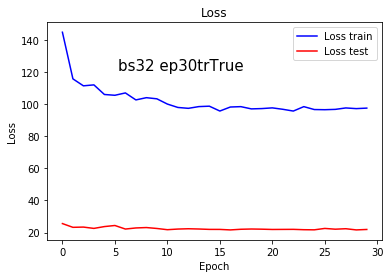

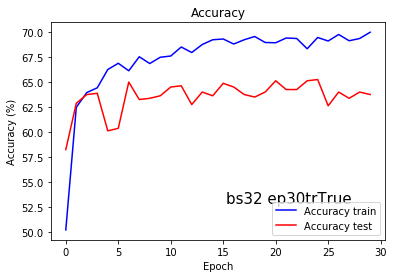

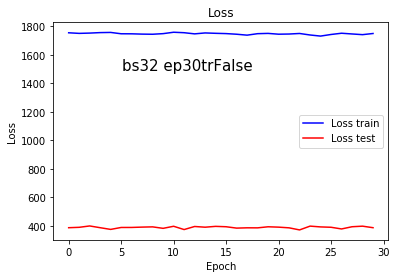

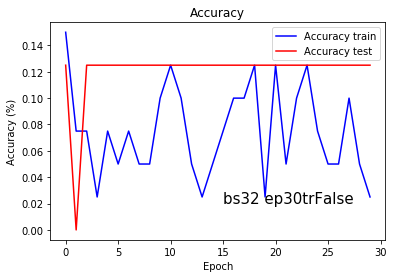

In [43]:
plot(batch_size=32, epoch=30, transfert=True)
plot(batch_size=32, epoch=30, transfert=False)